The aim of this exercise is to predict the demand of physicians in the US, measured as rate of physicians per 100k inhabitants at the US county-level, based on socio-demographic variables and then compare the performance of a linear regression versus lasso regression

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# Opening Data

In [2]:
link='https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
health_raw=pd.read_csv(link)

Data Description: [here](https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/data_dict.csv)

In [3]:
health_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


Data has several variables. First, I will delete the columns that do not add relevant information to the model such as the confidence intervarls (CI):

In [4]:
cols=[s for s in health_raw.columns if 'CI' in s] #List comprenhension extracting CI variables
print(cols)

health_raw.drop(cols, axis=1, inplace=True)

['CI90LBINC_2018', 'CI90UBINC_2018', 'anycondition_Lower 95% CI', 'anycondition_Upper 95% CI', 'Obesity_Lower 95% CI', 'Obesity_Upper 95% CI', 'Heart disease_Lower 95% CI', 'Heart disease_Upper 95% CI', 'COPD_Lower 95% CI', 'COPD_Upper 95% CI', 'diabetes_Lower 95% CI', 'diabetes_Upper 95% CI', 'CKD_Lower 95% CI', 'CKD_Upper 95% CI']


From the data description I can tell there is redundant information. Meaning that there are several variables measuring the same thing (e.g. race is measured as % and also as the total number of people within one category. Same for education, and other variables). Most of the time researchers do not work with absolute numbers (e.g., total population). Instead, they transform those absolute numbers into something else such an index, rate, percentages, standardisation, etc as they are not only easier to work with but also easier for making comparisons and interpreting.

In the following code I delete vabiables that contain absolut numbers for:

*   age groups
*   Duplicated age variables e.g. Population Aged 60+, Percent of Population Aged 60+, county_pop2018_18 and older
*   Variable of total population
*   race/ethnicity
*   Level of education
*   Total number of employed and unemployed people
*   Number of people with a certain health condition



In [5]:
#Obtaining varlist with age groups:
age=[s for s in health_raw.columns if s[0].isdigit() and 'y/o % of total pop' not in s]
print(age)
#list of duplicated age variables & total population variable
double=['Population Aged 60+', 'Percent of Population Aged 60+', 'TOT_POP', 'Total Population','county_pop2018_18 and older']

#Obtaining list of variables of total population by ethnicity:
ethn=[s for s in health_raw.columns if '-alone pop'  in s or 'Two or more races pop' in s]
print(ethn)

#Obtaining list of variables of total population by level of education:
educ=[s for s in health_raw.columns if '2014-18' in s and 'Percent' not in s]
print(educ)

#Total number of employed and unemployed people
emp=[s for s in health_raw.columns if 'mployed_2018' in s and 'rate' not in s]
print(emp)

#Obtaining Number of people with a certain health condition variables
sick=[s for s in health_raw.columns if '_number'in s]
print(sick)

to_drop=age + double+ ethn + educ + emp + sick
print(to_drop)

health_raw.drop(to_drop, axis=1, inplace=True)

['0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
['White-alone pop', 'Black-alone pop', 'Native American/American Indian-alone pop', 'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 'Two or more races pop']
['Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18"]
['Employed_2018', 'Unemployed_2018']
['anycondition_number', 'Obesity_number', 'Heart disease_number', 'COPD_number', 'diabetes_number', 'CKD_number']
['0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Population Aged 60+', 'Percent of Population Aged 60+', 'TOT_POP', 'Total Population', 'county_pop2018_18 and older', 'White-alone pop', 'Black-alone pop', 'Native American/American Indian-alone pop', 'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 'Two or more races pop', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-

Narrowed it down to 62 Variables:

In [6]:
health_raw.shape

(3140, 62)

There is no duplicated data:

In [7]:
print(health_raw.duplicated().sum())

0


Apriori there seems to be no missing data:

In [8]:
health_raw.isnull().sum().sort_values(ascending=False)


fips                                                                       0
Total Hospitals (2019)                                                     0
MEDHHINC_2018                                                              0
Civilian_labor_force_2018                                                  0
Unemployment_rate_2018                                                     0
                                                                          ..
Percent of adults with less than a high school diploma 2014-18             0
Percent of adults with a high school diploma only 2014-18                  0
Percent of adults completing some college or associate's degree 2014-18    0
Percent of adults with a bachelor's degree or higher 2014-18               0
Urban_rural_code                                                           0
Length: 62, dtype: int64

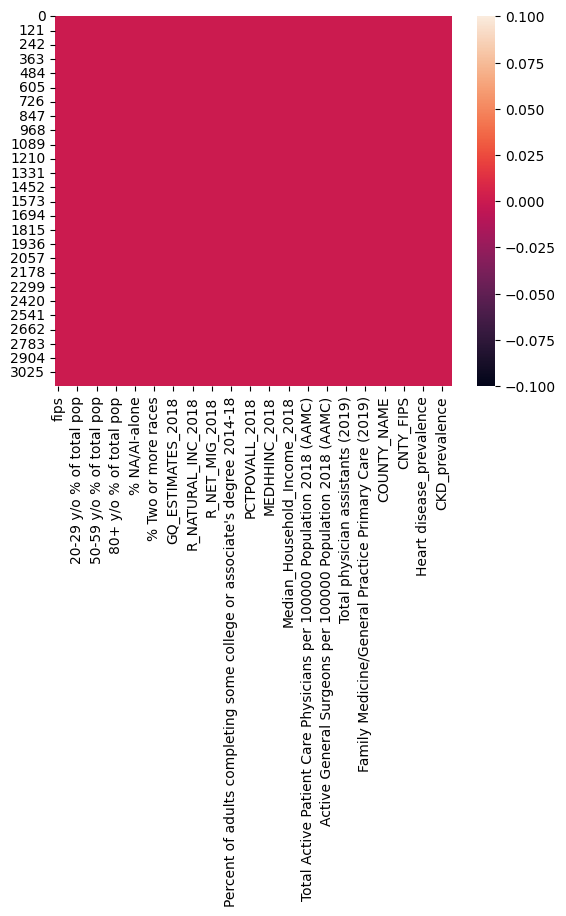

In [9]:
sns.heatmap(health_raw.isnull())
plt.show()

# Exploratory data analysis

## Univariate analysis

In [10]:
health_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
fips,3140.0,30401.640764,15150.559265,1001.000000,18180.500000,29178.000000,45081.500000,5.604500e+04
0-9 y/o % of total pop,3140.0,11.871051,2.124081,0.000000,10.594639,11.802727,12.951840,2.546068e+01
10-19 y/o % of total pop,3140.0,12.694609,1.815044,0.000000,11.674504,12.687422,13.659282,2.330437e+01
20-29 y/o % of total pop,3140.0,12.283979,3.126297,0.000000,10.496774,11.772649,13.182260,3.757020e+01
30-39 y/o % of total pop,3140.0,11.751535,1.696599,6.092789,10.689322,11.580861,12.639379,2.222513e+01
40-49 y/o % of total pop,3140.0,11.556685,1.372935,2.631579,10.685197,11.618372,12.386083,1.943037e+01
50-59 y/o % of total pop,3140.0,13.526733,1.481692,5.316361,12.738561,13.621339,14.429115,2.045455e+01
60-69 y/o % of total pop,3140.0,13.182225,2.532498,3.444403,11.621232,13.013409,14.467254,2.727273e+01
70-79 y/o % of total pop,3140.0,8.399382,2.214915,2.199551,7.032275,8.208162,9.445777,3.132796e+01
80+ y/o % of total pop,3140.0,4.733801,1.535028,0.000000,3.738648,4.565338,5.484143,2.272727e+01


### Overall distribution of the proportion of different age groups:

The distribution of agre groups for each county follows a symetrical distribution in most cases, except for the elderly groups

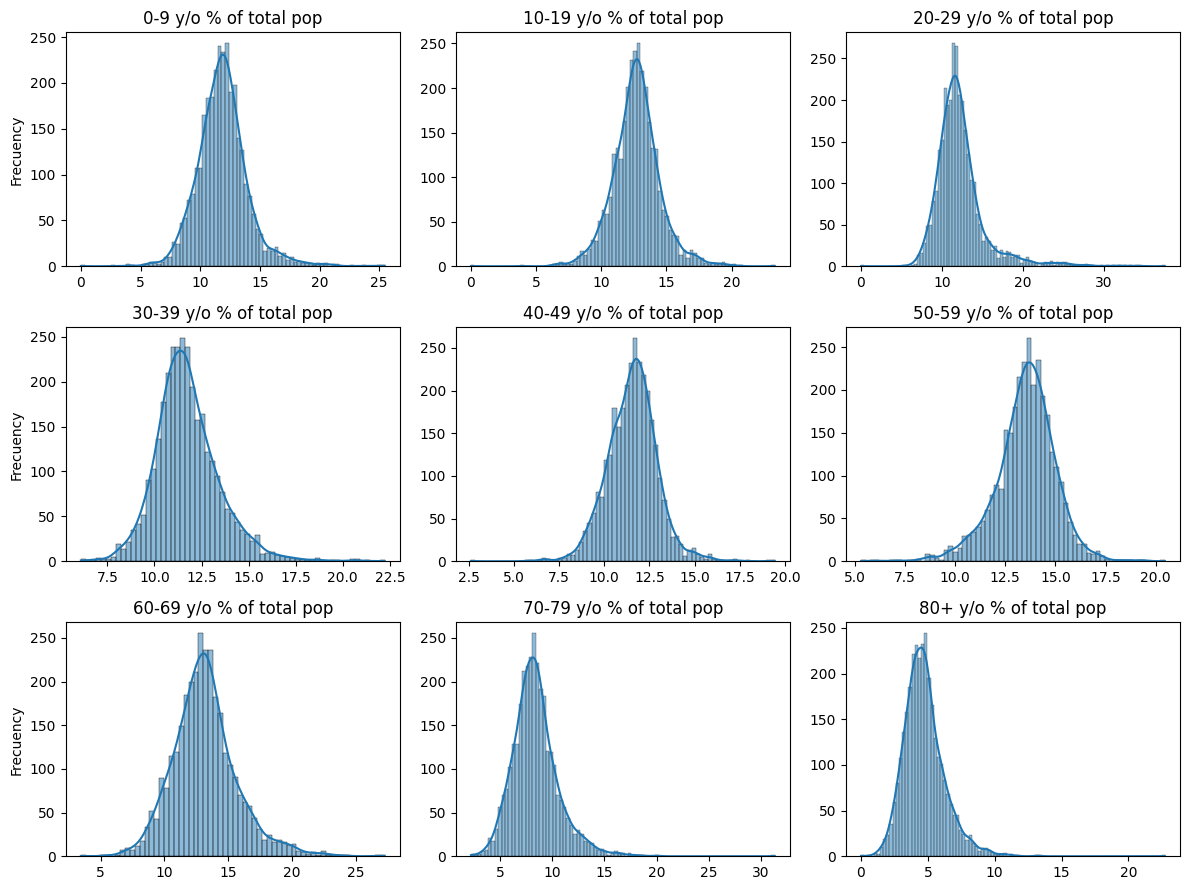

In [11]:
age=[s for s in health_raw.columns if s[0].isdigit()]
#print(age)

cols=3
rows=((len(age) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(age, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')
axis[2,0].set_ylabel('Frecuency')

#removing empty subplots
for i in range(len(age), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

### Overall distribution of the proportion of different ethnicities:

There seem to be outliers for native american, asian and hawaian, which are expected at least for natives and hawaians given that the number of people from these ethic groups is smaller, compared to other ethnicities, and often concentrate in certain areas of the US.

From the graphs we can observer that the US population is majority white, black or more than two ethnicities

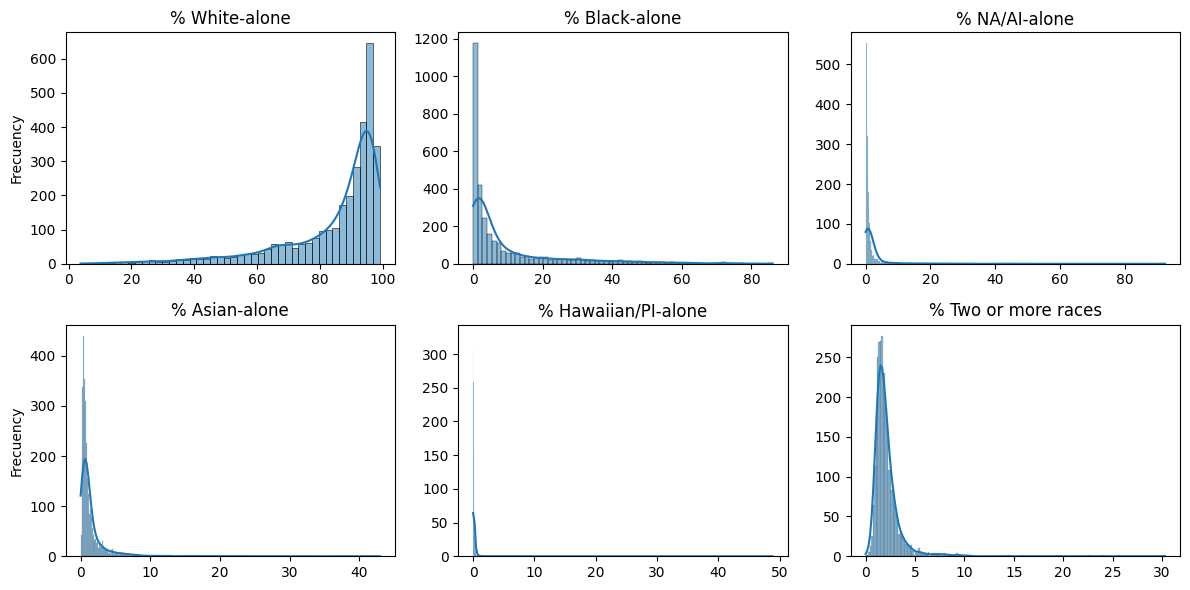

In [12]:
ethn=[s for s in health_raw.columns if '-alone'  in s or '% Two or more races' in s]
#print(ethn)

cols=3
rows=((len(ethn) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(ethn, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(ethn), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

### Distribution of healthcare staff/facilities variables

#### Histograms

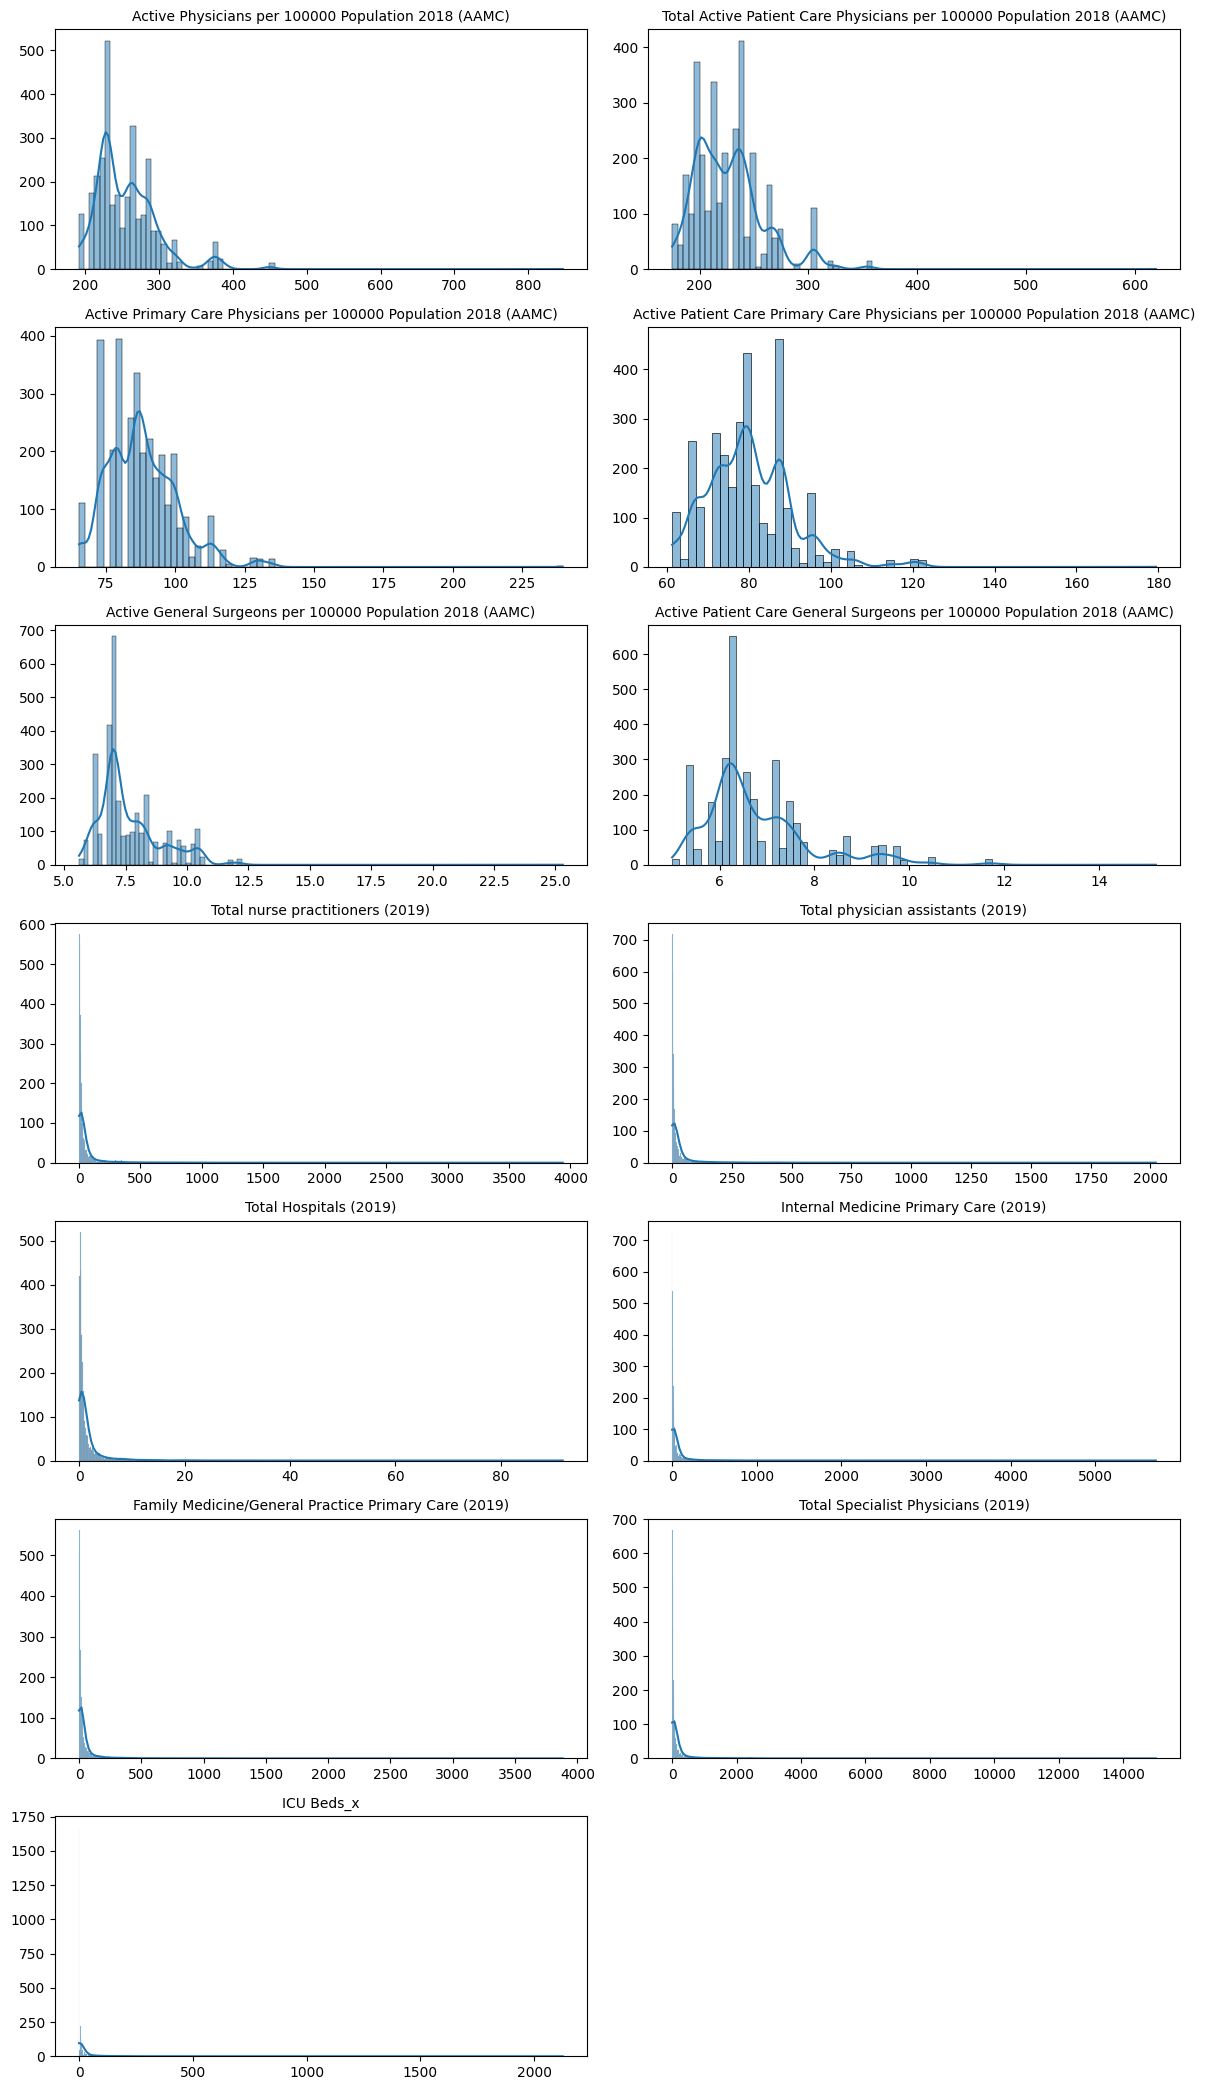

In [13]:
med=[s for s in health_raw.columns if 'Active'  in s or 'Total ' in s or 'Medicine' in s or 'ICU' in s]
# print(len(med))
# print(med)

cols=2
rows=((len(med) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(med, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col, fontsize=10)
  ax.set_ylabel('')
  ax.set_xlabel('')

# axis[0,0].set_ylabel('Frecuency')
# axis[1,0].set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(med), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

### Distributions of prevalence of health conditions

6
['Active Physicians per 100000 Population 2018 (AAMC)', 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)', 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)', 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)', 'Total nurse practitioners (2019)', 'Total physician assistants (2019)', 'Total Hospitals (2019)', 'Internal Medicine Primary Care (2019)', 'Family Medicine/General Practice Primary Care (2019)', 'Total Specialist Physicians (2019)', 'ICU Beds_x']


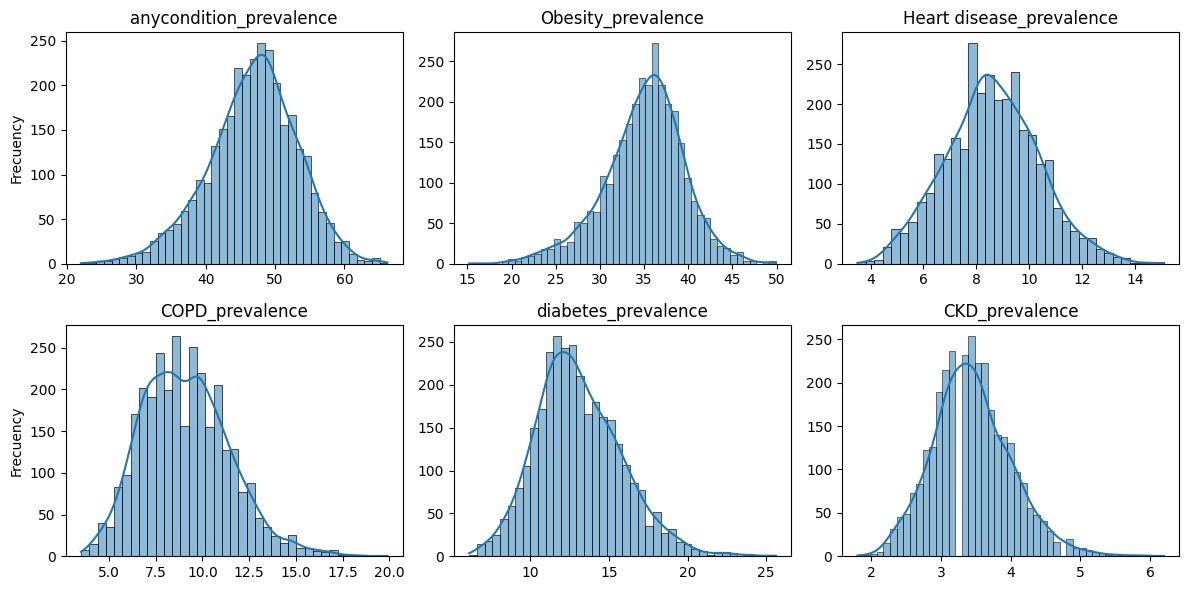

In [14]:
sick=[s for s in health_raw.columns if '_prevalence'  in s]
print(len(sick))
print(med)

cols=3
rows=((len(sick) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(sick, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(sick), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

## Multivariate analysis

### Correlations

As expected, health staff/resources variables are highly correlated, which means imperfect multicollinearity, and could affect the model if these variables are included on the linear regression as explanatory variables (later on I explain in more detail how imperfect multicollinearity affects linear models).

For the purpose of this exercise, all these variables will remain in the database. I expect that they will harm the performance of the linear regression and that the lasso regression will be able to pick up the collinear covariates and set their coefficients equal to zero

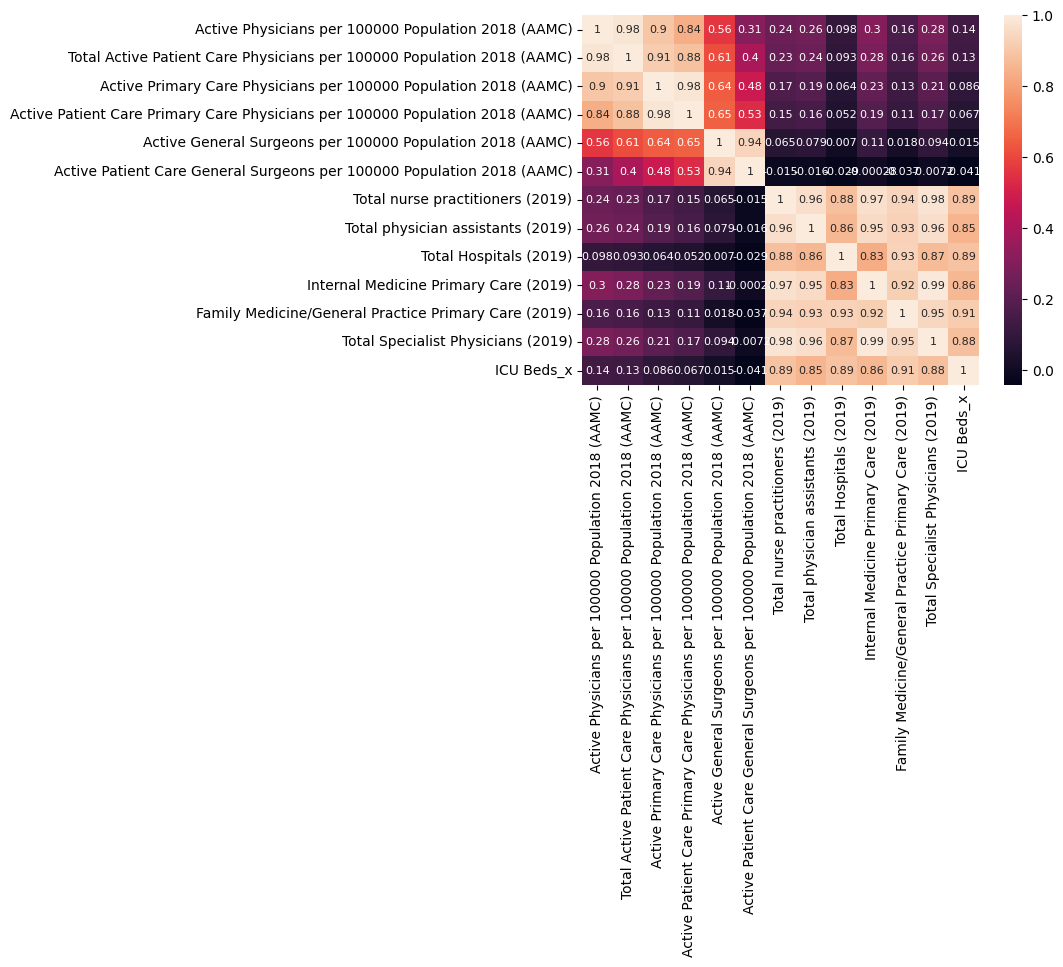

In [15]:
sns.heatmap(health_raw[med].corr(), annot=True, annot_kws={'fontsize':8})
plt.show()

### Relationship between health conditions and physicians per 100k population:

Extreme value detected for the dependent variable physicians per 100k population

['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', '% Hawaiian/PI-alone', '% Two or more races', '0-9 y/o % of total pop', '10-19 y/o % of total pop', '20-29 y/o % of total pop', '30-39 y/o % of total pop', '40-49 y/o % of total pop', '50-59 y/o % of total pop', '60-69 y/o % of total pop', '70-79 y/o % of total pop', '80+ y/o % of total pop', 'Active Physicians per 100000 Population 2018 (AAMC)']


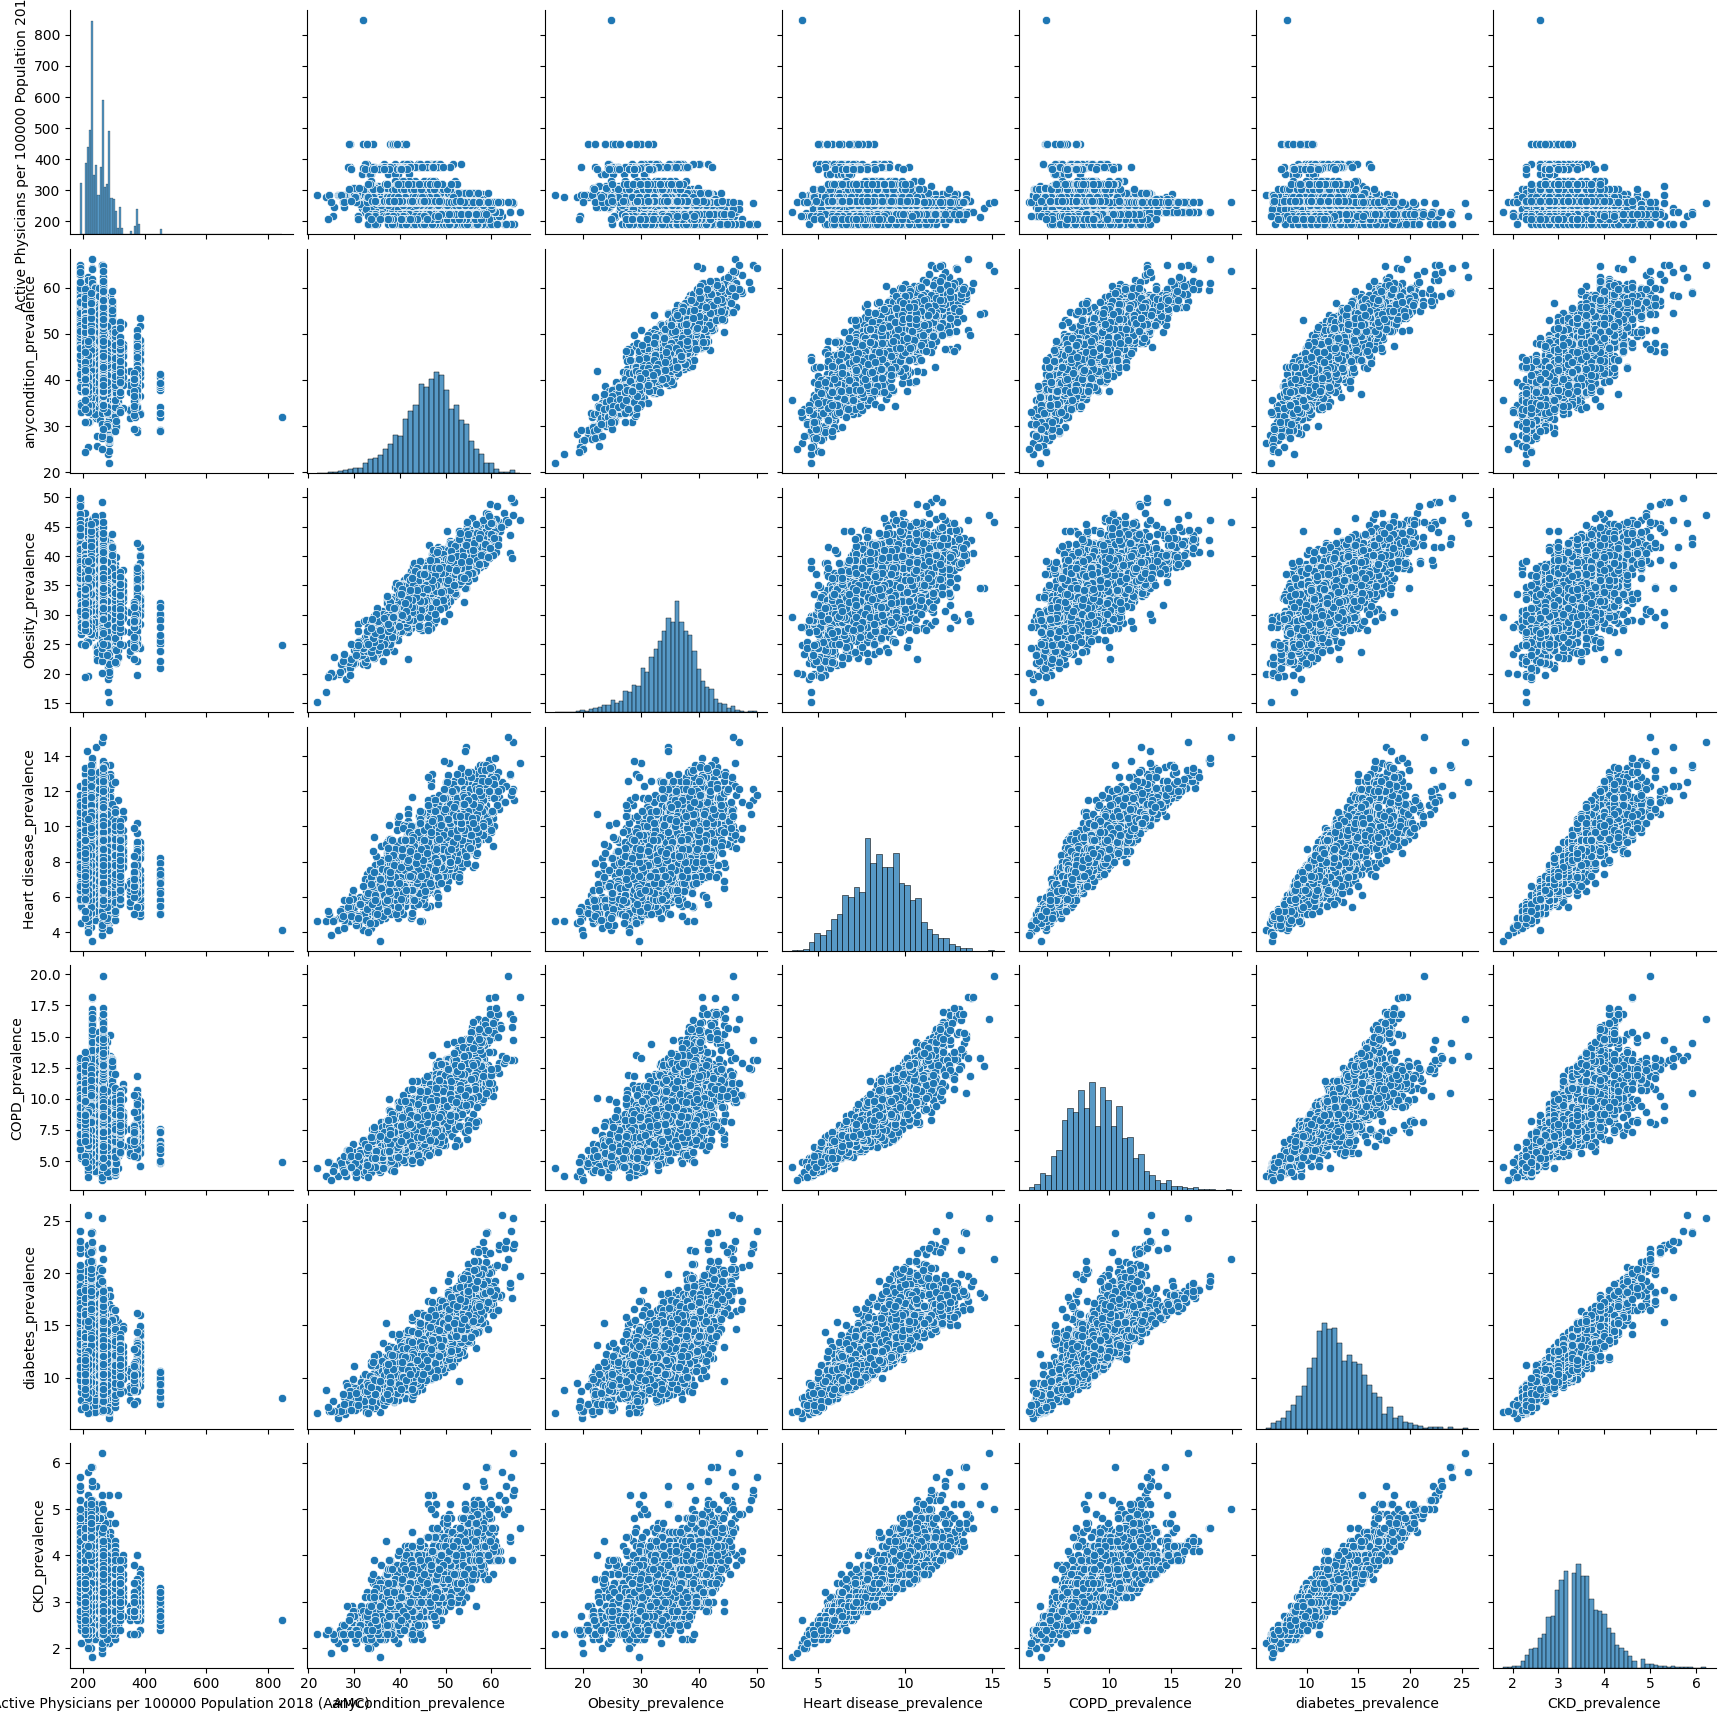

In [16]:
c=ethn+age+[med[0]] #Here I am selecting the ethnicity, age, and medical variables of interest
print(c)
sns.pairplot(health_raw[[med[0]]+sick], corner=False)
plt.show()

**Removing extreme values:**

There is only one extreme value to remove

In [17]:
condition=health_raw['Active Physicians per 100000 Population 2018 (AAMC)']>600
health_raw[condition]['Active Physicians per 100000 Population 2018 (AAMC)'].value_counts()
health_raw.drop(health_raw[condition].index, inplace=True)

Re-doing pairplot after removing extreme value:

* The pairplot shows that health conditions are related to each other, meaning that they are comorbidities as these types of health conditions do not occur isolated. Patients often suffer more than one of these conditions at the same time

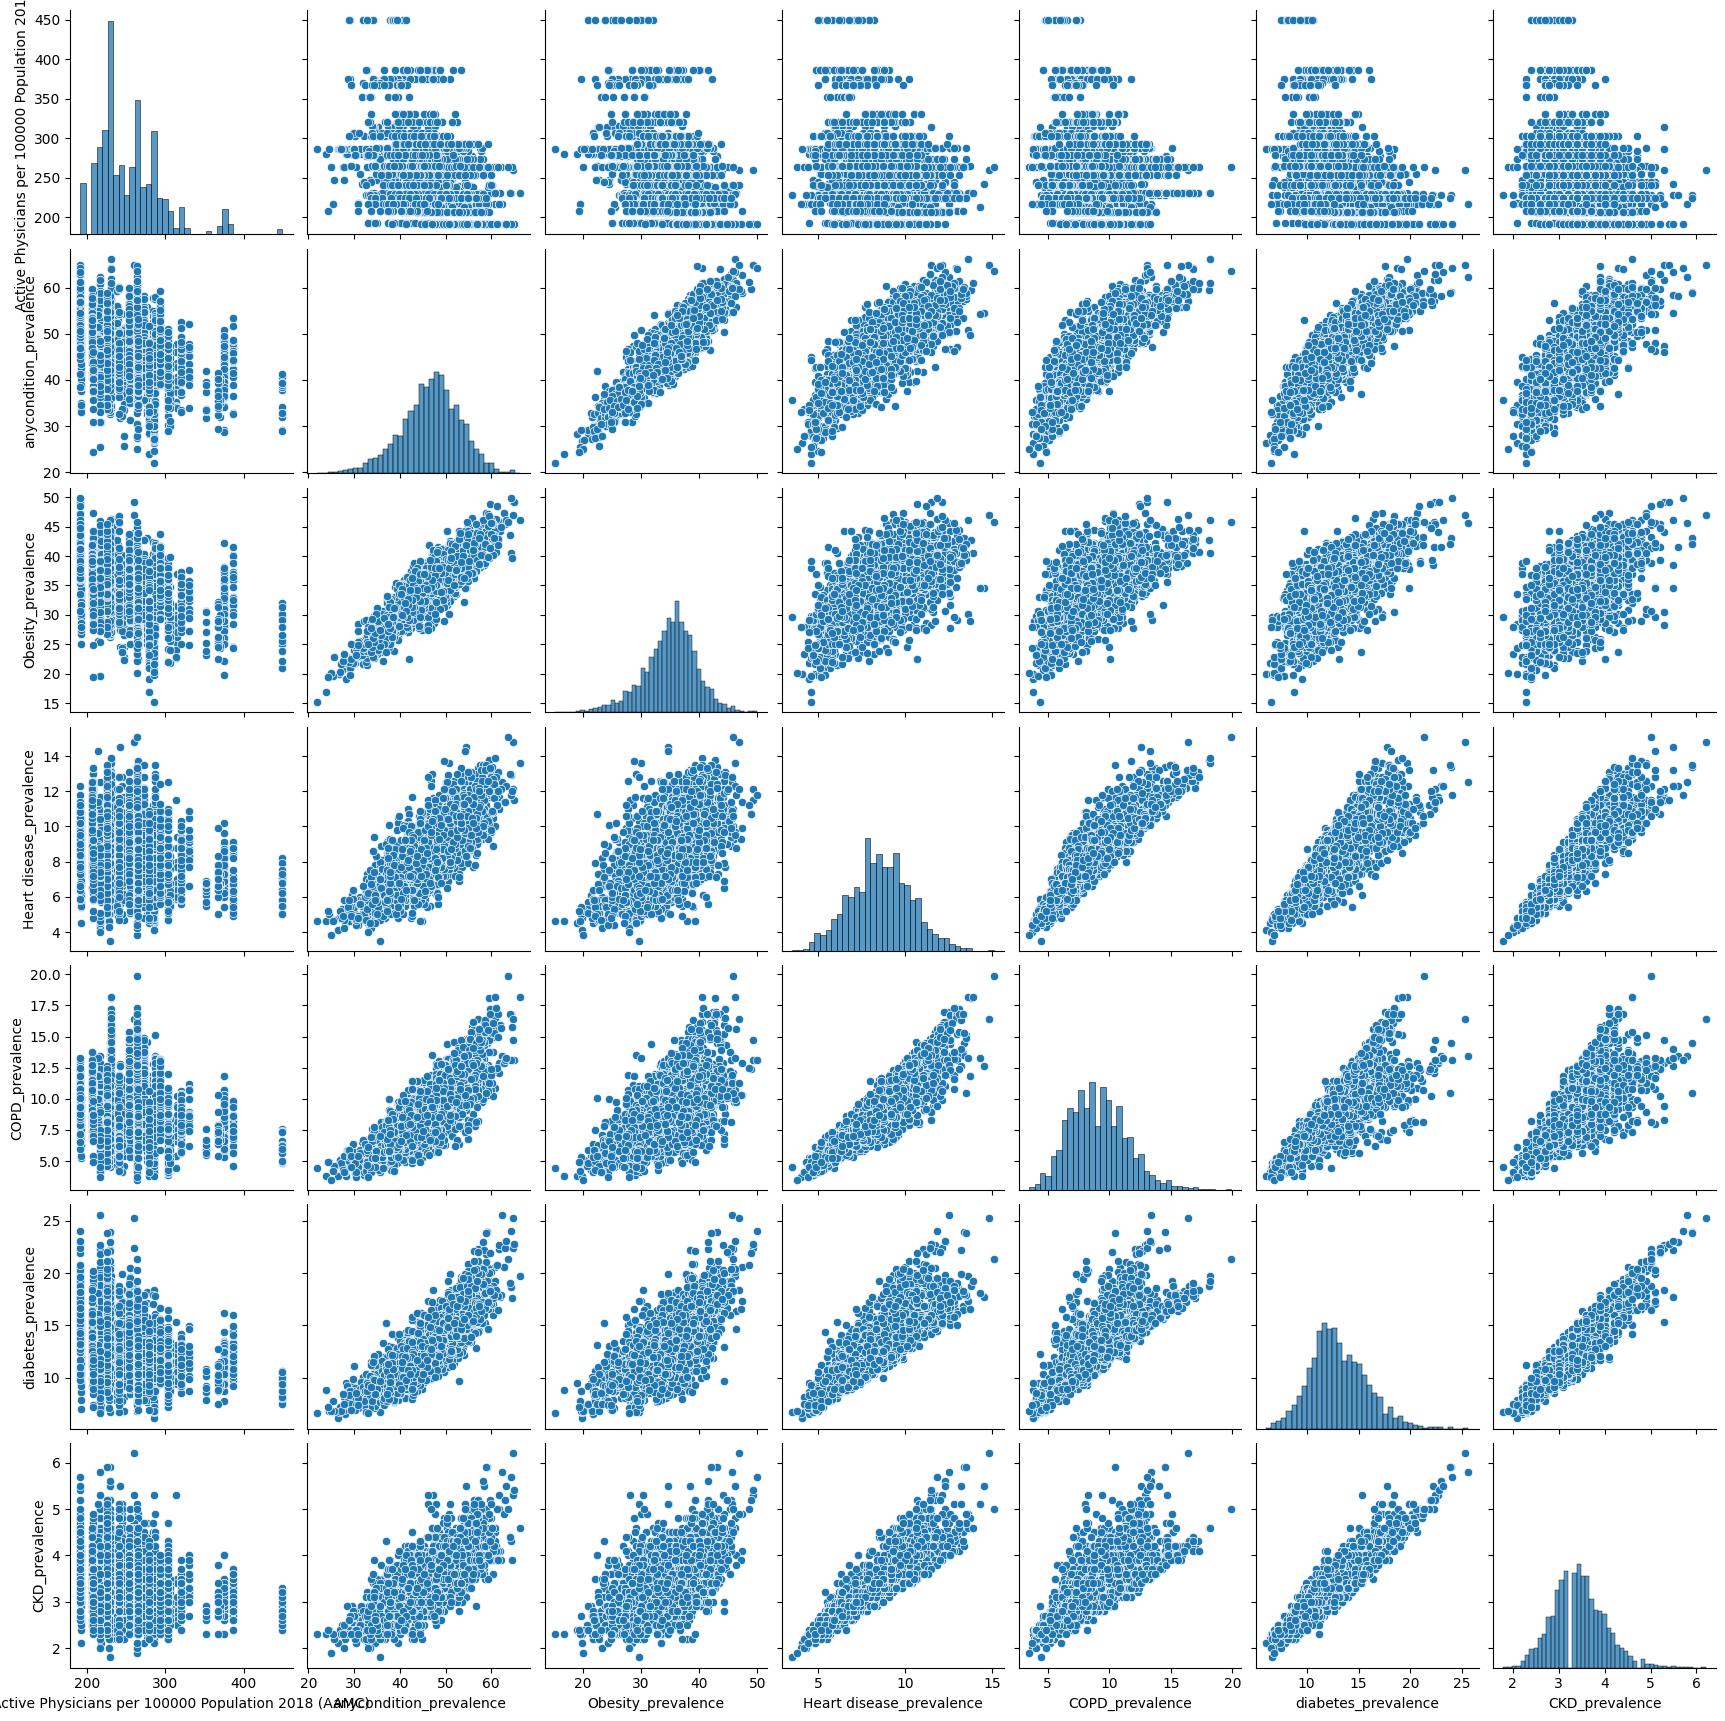

In [18]:
sns.pairplot(health_raw[[med[0]]+sick], corner=False)
plt.show()

# Data cleaning - Final steps

## Final steps before splitting data

First, I will remove ID variables that will not be used such as: fips, COUNTY_NAME, STATE_FIPS, CNTY_FIPS

In [19]:
health_raw.drop(['fips', 'COUNTY_NAME', 'STATE_FIPS', 'CNTY_FIPS'], inplace=True, axis=1)

Next, I will add dummy/binary variables for each state to account for the fact that demographic and health-related observations within each state are correlated because counties belonging to the same state share similar culture, environment, and laws. For example, within the state of Arkansas, a state in southern US, counties share similarities as they face the same state laws and culture. Whereas the counties inside California, western US, share similar culture and same state laws but they are completely different from those in Arkansas. 

In [20]:
health_raw=pd.get_dummies(health_raw, columns=['STATE_NAME'], prefix='state_', drop_first=True)

Now the data has 106 columns that include the roughly 50+ US states and territories

In [21]:
health_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3139 entries, 0 to 3139
Columns: 106 entries, 0-9 y/o % of total pop to state__Wyoming
dtypes: bool(49), float64(48), int64(9)
memory usage: 1.5 MB


## Splitting data

In [22]:
X=health_raw.drop('Active Physicians per 100000 Population 2018 (AAMC)', axis=1)
y=health_raw['Active Physicians per 100000 Population 2018 (AAMC)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data scaling

In [23]:
scaler=StandardScaler()
scaler.fit(X_train)

X_train_sc=pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_sc=pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

Storing scaled and unscaled data:

In [24]:
X_train.to_csv('/workspaces/US-health-ML/data/interim/X_train_sc.csv', index=False) #UNscaled
X_train_sc.to_csv('/workspaces/US-health-ML/data/interim/X_train_sc.csv', index=False) #Scaled
open("/workspaces/US-health-ML/data/interim/y_train.txt", "w").write(y_train.to_string(index=False))

X_test.to_csv('/workspaces/US-health-ML/data/interim/X_test.csv', index=False) #UNscaled
X_test_sc.to_csv('/workspaces/US-health-ML/data/interim/X_test_sc.csv', index=False) #Scaled
open("/workspaces/US-health-ML/data/interim/y_test.txt", "w").write(y_test.to_string(index=False))

dump(scaler, open('/workspaces/US-health-ML/data/interim/mm_scaler.pk', 'wb')) #storing scaler
